In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
vid_cap = cv2.VideoCapture('LaneVideo.mp4')
success, image = vid_cap.read()

if success:
    frame = cv2.resize(image, (640,480))
else:
    print("Video Loading Unsuccessful")

In [ ]:
def nothing(x):
    pass

cv2.namedWindow("Trackbars")

cv2.createTrackbar("L - H", "Trackbars", 0, 255, nothing)
cv2.createTrackbar("L - S", "Trackbars", 0, 255, nothing)
cv2.createTrackbar("L - V", "Trackbars", 200, 255, nothing)
cv2.createTrackbar("U - H", "Trackbars", 255, 255, nothing)
cv2.createTrackbar("U - S", "Trackbars", 189, 255, nothing)
cv2.createTrackbar("U - V", "Trackbars", 255, 255, nothing)

bl = (165, 570)
br = (900, 570)
tl = (330, 375)
tr = (600, 375)

while True:
    cv2.circle(frame, bl, 5, (0,0,255), -1)
    cv2.circle(frame, br, 5, (0,0,255), -1)
    cv2.circle(frame, tl, 5, (0,0,255), -1)
    cv2.circle(frame, tr, 5, (0,0,255), -1)

    #Aplying perspective transformation
    pts1 = np.float32([tl, bl, tr, br,]) 
    pts2 = np.float32([[0, 0], [0, 480], [640, 0], [640, 480]]) 


    # Matrix to warp the image for birdseye window
    matrix = cv2.getPerspectiveTransform(pts1, pts2) 
    transformed_frame = cv2.warpPerspective(frame, matrix, (640,480))
    print()

    hsv_transformed_frame = cv2.cvtColor(transformed_frame, cv2.COLOR_BGR2HSV)
        
    l_h = cv2.getTrackbarPos("L - H", "Trackbars")
    l_s = cv2.getTrackbarPos("L - S", "Trackbars")
    l_v = cv2.getTrackbarPos("L - V", "Trackbars")
    u_h = cv2.getTrackbarPos("U - H", "Trackbars")
    u_s = cv2.getTrackbarPos("U - S", "Trackbars")
    u_v = cv2.getTrackbarPos("U - V", "Trackbars")

    lower = np.array([l_h,l_s,l_v])
    upper = np.array([u_h,u_s,u_v])
    mask = cv2.inRange(hsv_transformed_frame, lower, upper)

    histogram = np.sum(mask[mask.shape[0]//2:, :], axis=0)
    midpoint = int(histogram.shape[0]/2)
    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint

    y = 710
    lx = []
    rx = []

    msk = mask.copy()

    while y>0:
        ## Left threshold
        img = mask[y-40:y, left_base-75:left_base+75]
        contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"]/M["m00"])
                cy = int(M["m01"]/M["m00"])
                lx.append(left_base-50 + cx)
                left_base = left_base-50 + cx
        
        ## Right threshold
        img = mask[y-40:y, right_base-50:right_base+50]
        contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"]/M["m00"])
                cy = int(M["m01"]/M["m00"])
                rx.append(right_base-50 + cx)
                right_base = right_base-50 + cx
        
        cv2.rectangle(msk, (left_base-50,y), (left_base+50,y-40), (255,255,255), 2)
        cv2.rectangle(msk, (right_base-50,y), (right_base+50,y-40), (255,255,255), 2)
        y -= 40
        
    # Ensure lx and rx are not empty
    if len(lx) == 0:
        lx = prevLx
    else:
        prevLx = lx
    if len(rx) == 0:
        rx = prevRx
    else:
        prevRx = rx

    # Ensure both lx and rx have the same length
    min_length = min(len(lx), len(rx))

    # Create the top and bottom points for the quadrilateral
    top_left = (lx[0], 710)
    bottom_left = (lx[min_length-1], 0)
    top_right = (rx[0], 710)
    bottom_right = (rx[min_length-1], 0)

    # Define the quadrilateral points
    quad_points = np.array([top_left, bottom_left, bottom_right, top_right], dtype=np.int32)

    # Reshape quad_points to the required shape for fillPoly
    quad_points = quad_points.reshape((-1, 1, 2))

    # Create a copy of the transformed frame
    overlay = transformed_frame.copy()

    # Draw the filled polygon on the transformed frame
    cv2.fillPoly(overlay, [quad_points], (0, 255, 0))

    alpha = 0.2 # Opacity factor
    cv2.addWeighted(overlay, alpha, transformed_frame, 1 - alpha, 0, transformed_frame)

    # Display the transformed frame with the highlighted lane
    cv2.imshow("Transformed Frame with Highlighted Lane", overlay)

    # Inverse perspective transformation to map the lanes back to the original image
    inv_matrix = cv2.getPerspectiveTransform(pts2, pts1)
    original_perpective_lane_image = cv2.warpPerspective(transformed_frame, inv_matrix, (960, 720))

    # Combine the original frame with the lane image
    result = cv2.addWeighted(frame, 1, original_perpective_lane_image, 0.5, 0)

    # cv2.imshow("Original", frame)
    # cv2.imshow("Bird's Eye Prespective", transformed_frame)
    # cv2.imshow("Masked Image", mask)
    cv2.imshow("Lane Detection", result)

    if (cv2.waitKey(10) == 27):
        break


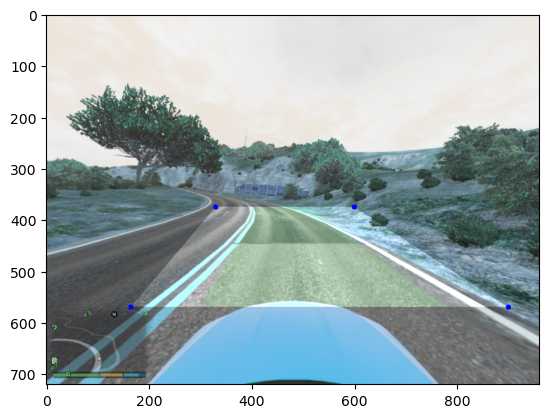

In [7]:
plt.imshow(result)

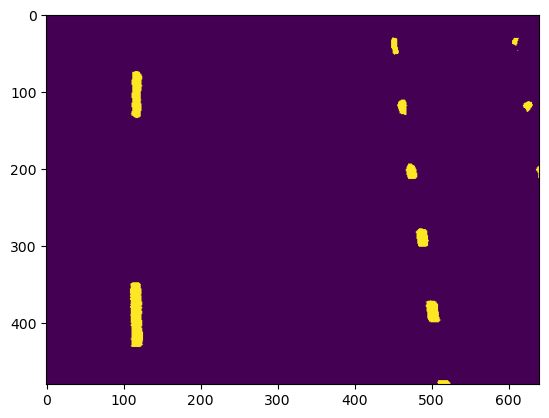

In [8]:
plt.imshow(frame)
plt.imshow(transformed_frame)
plt.imshow(mask)